# Basics: Exoplanet systems
Here we'll discuss how to instantiate an exoplanet system and compute its full light curve. Currently, all orbital stuff lives in the `starry.kepler` module, which implements a simple Keplerian solver. This works for systems of exoplanets orbiting stars, moons orbiting planets, and binary star systems. Keep in mind, however, that the primary object is assumed to sit at the origin, and the secondary objects are assumed to be massless. A more flexible N-body solver will be added in the next version of the code, so stay tuned!

## Creating a star

This is as easy as it gets:

In [ ]:
%matplotlib inline

In [1]:
import starry
star = starry.kepler.Primary()

A `kepler.Primary` object is just a body that sits at the origin and either occults or gets occulted by other bodies, so you don't have too much freedom in settings its properties. For one, its radius and luminosity are fixed at unity: this sets the units for the properties of the `Secondary` bodies, since those bodies' radii, semi-major axes, and luminosities are specified in units of the `Primary`. You can, however, specify spherical harmonic and/or limb darkening coefficients, an axis of rotation, and a rotational period. In fact, the `kepler.Primary` class is a subclass of the `Map` class, so everything you can do with a `Map` you can do here, too. Check out the `Spotted star` tutorial for some ideas.

As a simple example, let's set the limb darkening coefficients of the star. Let's give the stellar map a linear and a quadratic limb-darkening coefficient:

In [2]:
star[1] = 0.40
star[2] = 0.26

Here's what that looks like:

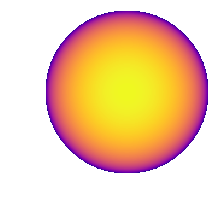

In [14]:
star.show()

## Creating a planet

Let's create a (very) hot Jupiter with some interesting properties:

In [4]:
planet = starry.kepler.Secondary(lmax=5)
planet.r = 0.1
planet.L = 5e-3
planet.porb = 1
planet.prot = 1
planet.a = 30
planet.Omega = 30
planet.ecc = 0.3
planet.w = 30

Here we've instantiated a planet with a fifth degree surface map, a radius that is one-tenth that of the star, a luminosity that is one-two-hundredth that of the star, an orbital period of 1 day, a rotational period of 1 day, and a semi-major axis that's thirty times the stellar radius. This is essentially a tidally-locked hot Jupiter.

**NOTE:** *The default rotational period for planets is **infinity**, so if you don't specify* `prot` *, the planet's surface map will not rotate as the planet orbits the star and there will be no phase curve variation. For planets whose emission tracks the star--i.e., a hot Jupiter with a hotspot--set* `prot=porb` *. Also note that the default luminosity is *zero*, so make sure to set that as well if you want any emission from the planet!*

There are a bunch of other settings related to the orbit, so check out the docs for those. By default, planets are given zero eccentricity, edge-on inclination, and zero obliquity, and $t = 0$ corresponds to a transiting configuration.

OK, the next thing we get to do is specify the planet's map. For simplicity, let's just create a random one:

In [5]:
import numpy as np
np.random.seed(123)
for l in range(1, planet.lmax + 1):
    for m in range(-l, l + 1):
        planet[l, m] = 0.01 * np.random.randn()

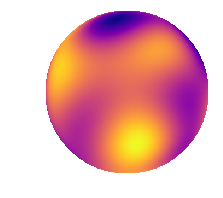

In [6]:
planet.show()

Note that when instantiating a map for a `starry.kepler.Secondary` instance, **the map should be defined as it would appear during occultation by the primary (i.e., secondary eclipse).** That is, the image you see above is the full dayside of the planet, with the orbital plane slicing the planet's equator and ecliptic north pointing up. **This is true even for planets that aren't edge on and don't have secondary eclipses.** The map is always defined as if it were seen edge on, with the orbital plane along the $xy$ plane and the planet behind the primary. Check out the [viewing geometry tutorial](geometry.html) for more information.

Now, it's probably a good idea to ensure we didn't end up with negative specific intensity anywhere:

In [7]:
planet.is_physical()

True

This routine performs gradient descent to try to find the global minimum of the map, and returns `True` if the minimum is greater than or equal to zero. Since it's determining this numerically, it's probably a good idea to avoid doing this repeatedly (say, in an MCMC problem).

## Creating a system

Now that we have a star and a planet, we can instantiate a planetary system:

In [8]:
system = starry.kepler.System(star, planet)

The first argument to a `starry.System` call is a `kepler.Primary` object, followed by any number of `kepler.Secondary` objects.

There are some other system attributes you can set--notably an exposure time (`exptime`)--if the exposure time of your data is long enough to affect the light curve shape. Check out the docs for more information.

## Computing light curves

We're ready to compute the full system light curve:

In [9]:
time = np.linspace(-0.25, 3.25, 10000)
%time system.compute(time)

CPU times: user 17.5 ms, sys: 461 µs, total: 17.9 ms
Wall time: 17.8 ms


Cool -- `starry` computed 10,000 cadences in 15 ms. Let's check it out:

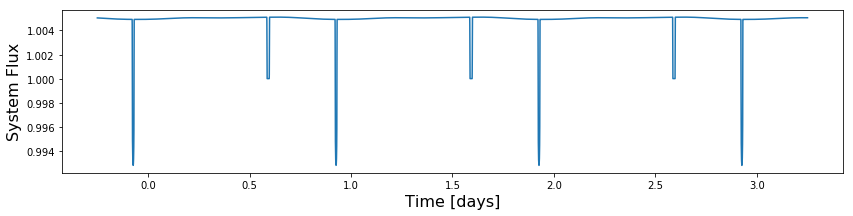

In [10]:
import matplotlib.pyplot as pl
%matplotlib inline
fig, ax = pl.subplots(1, figsize=(14, 3))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('System Flux', fontsize=16)
ax.plot(time, system.lightcurve);

We can also plot the stellar and planetary light curves individually:

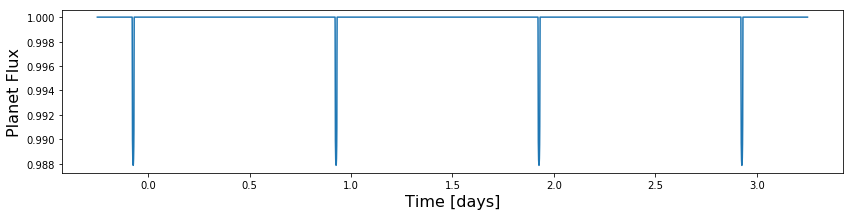

In [11]:
# This will show you only the transits
fig, ax = pl.subplots(1, figsize=(14, 3))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('Planet Flux', fontsize=16)
ax.plot(time, star.lightcurve);

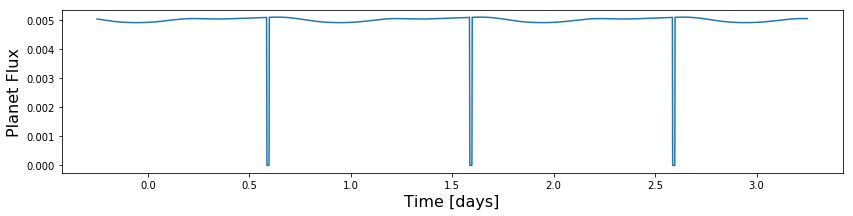

In [12]:
# This will show you only the planet's flux (phase curve + secondary eclipse)
fig, ax = pl.subplots(1, figsize=(14, 3))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('Planet Flux', fontsize=16)
ax.plot(time, planet.lightcurve);

And, just for fun, the planet's orbit (the sky plane is the $xy$ plane, with $y$ pointing up and $x$ pointing to the right; $z$ points toward the observer):

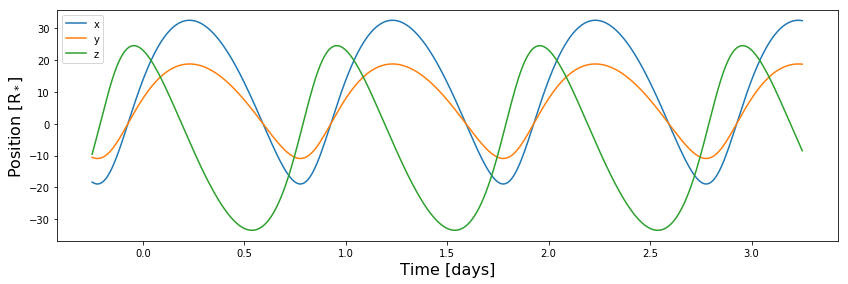

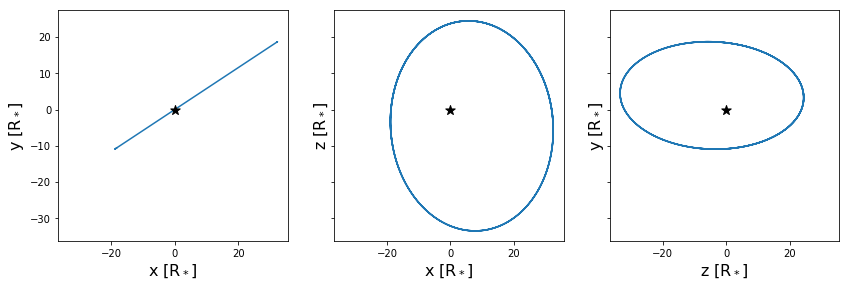

In [13]:
fig, ax = pl.subplots(1, figsize=(14, 4.25))
ax.plot(time, planet.X, label='x')
ax.plot(time, planet.Y, label='y')
ax.plot(time, planet.Z, label='z')
ax.set_ylabel(r'Position [R$_*$]', fontsize=16);
ax.set_xlabel(r'Time [days]', fontsize=16);
ax.legend();

fig, ax = pl.subplots(1,3, sharex=True, sharey=True, figsize=(14, 4.25))
ax[0].plot(planet.X, planet.Y)
ax[1].plot(planet.X, planet.Z)
ax[2].plot(planet.Z, planet.Y)
for n in [0, 1, 2]:
    ax[n].scatter(0, 0, marker='*', color='k', s=100, zorder=10)
ax[0].set_xlabel(r'x [R$_*$]', fontsize=16);
ax[0].set_ylabel(r'y [R$_*$]', fontsize=16);
ax[1].set_xlabel(r'x [R$_*$]', fontsize=16);
ax[1].set_ylabel(r'z [R$_*$]', fontsize=16);
ax[2].set_xlabel(r'z [R$_*$]', fontsize=16);
ax[2].set_ylabel(r'y [R$_*$]', fontsize=16);

## Comparison to `batman`

One last thing we can do is compare a simple transit calculation to what we'd get with the `batman` code [(Kreidberg 2015)](https://astro.uchicago.edu/~kreidberg/batman/), a widely used and well-tested light curve tool.

First, let's define all the system parameters:

In [24]:
u1 = 0.4        # Stellar linear limb darkening coefficient
u2 = 0.26       # Stellar quadratic limb darkening coefficient
rplanet = 0.1   # Planet radius in units of stellar radius
inc = 89.95      # Planet orbital inclination
P = 50          # Planet orbital period in days
a = 300         # Planet semi-major axis in units of stellar radius

We'll evaluate the light curve on the following time grid:

In [28]:
npts = 500
time = np.linspace(-0.1, 0.1, npts)

Let's evaluate the `starry` light curve for this system:

In [44]:
# Instantiate the star
star = starry.kepler.Primary()
star[1] = u1
star[2] = u2

# Instantiate the planet
planet = starry.kepler.Secondary()
planet.r = rplanet
planet.inc = inc
planet.porb = P
planet.a = a
planet.lambda0 = 90

# Instantiate the system
system = starry.kepler.System(star, planet)

# Compute and store the light curve
system.compute(time)
flux_starry = system.lightcurve

And now the `batman` light curve:

In [42]:
import batman
params = batman.TransitParams()
params.limb_dark = "quadratic"
params.u = [u1, u2]
params.t0 = 0.
params.ecc = 0.
params.w = 90.
params.rp = rplanet
params.a = a
params.per = P
params.inc = inc
m = batman.TransitModel(params, time)
flux_batman = m.light_curve(params)

Let's plot the two light curves:

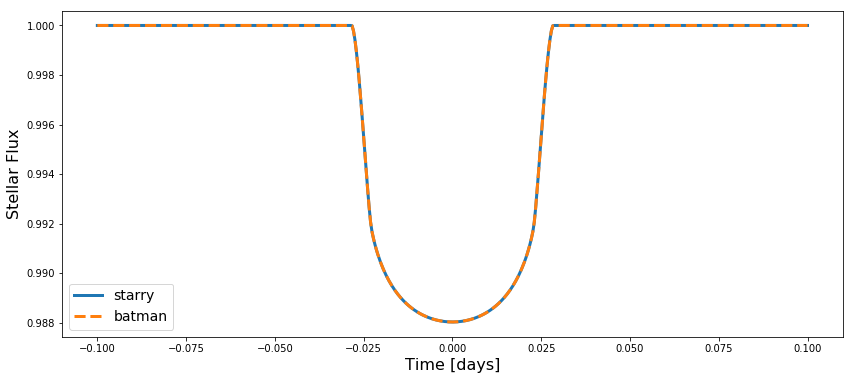

In [43]:
fig, ax = pl.subplots(1, figsize=(14, 6))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('Stellar Flux', fontsize=16)
ax.plot(time, flux_starry, label='starry', lw=3);
ax.plot(time, flux_batman, '--', label='batman', lw=3);
ax.legend(fontsize=14);

Here is the difference between the two models:

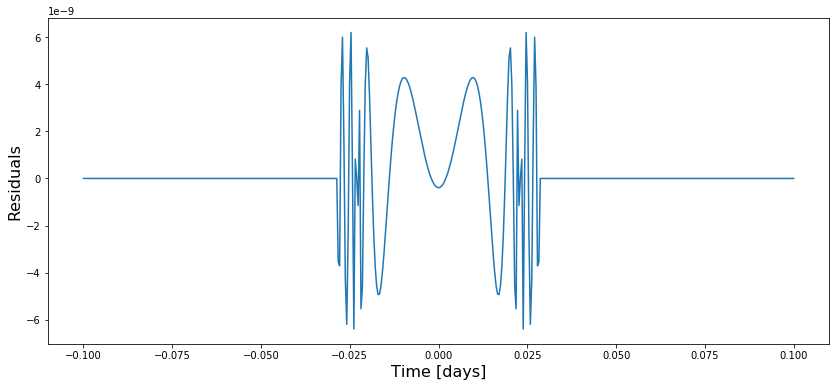

In [46]:
fig, ax = pl.subplots(1, figsize=(14, 6))
ax.set_xlabel('Time [days]', fontsize=16)
ax.set_ylabel('Residuals', fontsize=16)
ax.plot(time, flux_starry - flux_batman);

It's on the order of a few parts per billion, which is quite small. The oscillations are due to the fact that `batman` uses [Hasting's approximation](https://github.com/lkreidberg/batman/blob/master/c_src/_quadratic_ld.c#L304) to compute the elliptic integrals, which is slightly faster but leads to small errors. In practice, however, the two models are equivalent for exoplanet transit modeling.

**One final note.** You may have noticed that some of the parameters accepted by `batman` and `starry` are slightly different. While `batman` accepts the transit mid-point `t0` as an input parameter, `starry` accepts the mean longitude `lambda0` at the reference time `tref` instead. This is a bit more general and useful, for instance, in the case of non-transiting bodies. By default, `tref=0` and `lambda0=90`, corresponding to a transit time of `t0=0`. For eccentric orbits things can get a little tricky converting between these two conventions, but the way to do is to remember that the **true anomaly at the transit midpoint is** 

$f_{t_0} = \frac{\pi}{2} - \varpi$



where $\varpi$ is the longitude of pericenter, the `w` attribute of a `starry.kepler.Secondary` instance. Solving [Kepler's equation](https://en.wikipedia.org/wiki/Eccentric_anomaly) can then yield the time of the transit mid-point.

For circular orbits, the true anomaly, eccentric anomaly, and mean anomaly are all the same ($f = E = M$), and since $M = \lambda - \varpi$, we have $\lambda = \frac{\pi}{2}$ at the transit mid-point, as expected.